In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys
from loki import RingData #https://github.com/dermen/loki

sys.path.insert(0, '../src/')
from integrators import *
from calibrators import *

In [2]:
run = 'SilverBehenate_powderCalibration'
h5path = '/sf/bernina/data/p17743/res/work/hdf5/%s.h5'%run
h5file = h5py.File(h5path,'r')

In [3]:
img = h5file['JF7/2D_sum_hits']
hits = h5file['JF7/num_hits'].value
nshots = h5file['JF7/num_shots'].value

### guess center

In [4]:
center_guess = [2120,2225] #intital guess for center
peak_radius_guess = 190#2302-center_guess[0]
ring_param_guess = ( center_guess[0], center_guess[1], peak_radius_guess )

<IPython.core.display.Javascript object>


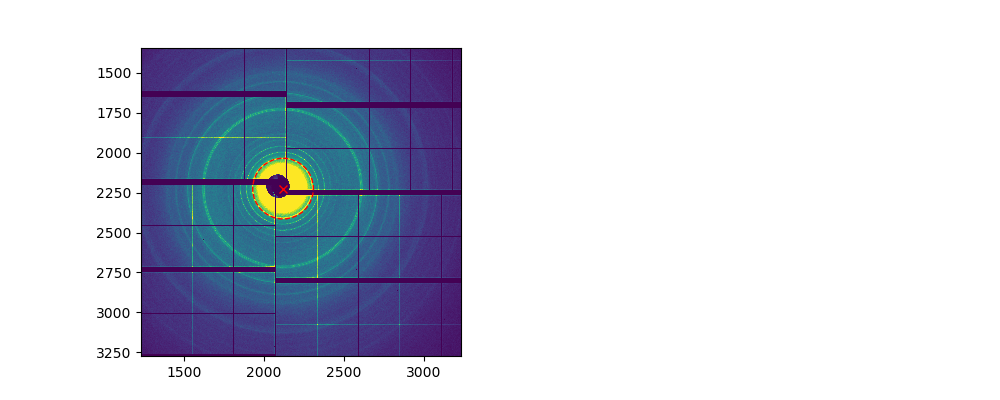

In [5]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
ax = plt.gca()
plt.plot(center_guess[0],center_guess[1],'rx')
circ = plt.Circle( xy=(center_guess[0], center_guess[1]), radius=peak_radius_guess, lw=1, fc='none', ls='dashed' ,color='r')
ax.imshow(img/hits, interpolation='nearest',clim=[0,10])
ax.add_patch( circ)
#plt.colorbar()

plt.show()

### fit ring (careful with the x and y!)

In [102]:
RF = RingData.RingFit(img)
x_center,y_center,peak_radius = RF.fit_circle_slow(ring_param_guess, 
                                            ring_scan_width=4, 
                                            center_scan_width=4, 
                                            resolution=1 )

/mnt/das-gpfs/home/ext-perakis_f/.local/lib/python3.6/site-packages/loki/RingData/RadialProfile.py:79: RuntimeWarning: invalid value encountered in true_divide
  self.num_pixels_per_radial_bin


### angular average

In [35]:
q_ref = silver_behenate()

In [93]:
n_bins = 5000
detector_distance = 0.1249
energy = 9500

mask = np.ones(img.shape,dtype=bool)
mask[img==0] = 0

# r-map
rad_dist = radial_distances(img, center=(int(y_center),int(x_center)))

#method 1
r,iq = angular_average(img, mask=mask, rad=rad_dist,threshold=0,nx=n_bins)
q = q_scale(r,detector_distance=detector_distance,photon_energy=energy)

# method 2
ra = RadialAverager(rad_dist, mask,n_bins=n_bins)
iq2 = ra(np.array(img))
r2  = ra.bin_centers
q2 = q_scale(r2,detector_distance=detector_distance,photon_energy=energy)

### plots

<IPython.core.display.Javascript object>


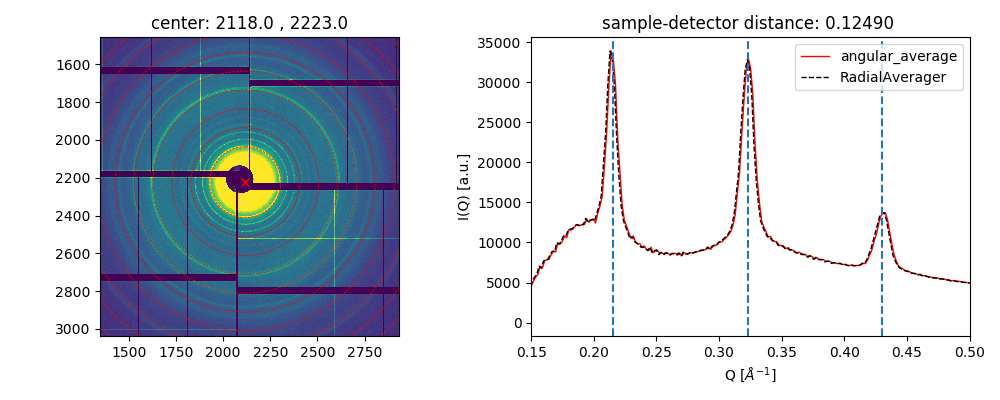

In [101]:
#plt.figure(figsize=[10,4])

plt.figure(figsize=[10,4])

plt.subplot(1,2,1)
ax = plt.gca()
plt.plot(x_center,y_center,'rx')

for i in range(10):
    circ = plt.Circle( xy=(x_center, y_center), radius=peak_radius+i*100, lw=0.5, fc='none', ls='dashed' ,color='r')
    ax.add_patch( circ)
ax.imshow(img/hits, interpolation='nearest',clim=[0,10])
plt.title('center: %.1f , %.1f'%(x_center,y_center))

plt.subplot(1,2,2)
plt.plot(q,iq,lw =1,c='red',label = 'angular_average',alpha=1)
plt.plot(q2,iq2,ls='--',lw =1,c='black',label = 'RadialAverager',alpha=1)

for i in range(1,4):
    plt.axvline(x = q_ref[i],ls ='--')

plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [a.u.]')
plt.xlim(0.15,0.5)
plt.legend()
plt.title('sample-detector distance: %.5f '%detector_distance)


plt.tight_layout()

plt.show()